Data Preparation

Import Libraries and load the MIMIC-III dataset and prepare for further processing.

In [1]:
# Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_c

In [37]:
def load_data(filepath, required_columns):
    data = pd.read_csv(filepath)
    data = data[required_columns]
    return data

def convert_datetime(data, column):
    return pd.to_datetime(data[column])

In [38]:
filepath1='mimic-iii-clinical-database-demo-1.4/PATIENTS.csv'
filepath2='mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv'
filepath3='mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv'

required_columns1=['subject_id', 'gender', 'dob', 'dod']
required_columns2=['subject_id', 'hadm_id', 'ethnicity', 'dischtime']
required_columns3=['subject_id', 'hadm_id', 'icustay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los']

In [39]:
# Load the PATIENTS, ADMISSIONS, & ICUSTAYS data from MIMIC-III dataset 
data_patients = load_data(filepath1, required_columns1)
data_admissions = load_data(filepath2, required_columns2)
data_icustays = load_data(filepath3, required_columns3)

In [42]:
# Display basic information about the dataset
display(Markdown("#### Basic Information on PATIENTS"))
print(data_patients.shape)
print(data_patients.info())
print(data_patients.describe())

display(Markdown("#### Basic Information on ADMISSIONS"))
print(data_admissions.shape)
print(data_admissions.info())
print(data_admissions.describe())

display(Markdown("#### Basic Information on ICUSTAYS"))
print(data_icustays.shape)
print(data_icustays.info())
print(data_icustays.describe())

#### Basic Information on PATIENTS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  100 non-null    int64         
 1   gender      100 non-null    object        
 2   dob         100 non-null    object        
 3   dod         100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.2+ KB
None
(100, 4)
         subject_id                  dod
count    100.000000                  100
mean   26162.330000  2151-06-09 17:02:24
min    10006.000000  2105-02-16 00:00:00
25%    10068.500000  2128-09-12 12:00:00
50%    25128.000000  2150-09-01 12:00:00
75%    42276.500000  2172-03-18 06:00:00
max    44228.000000  2202-12-05 00:00:00
std    16201.834705                  NaN


#### Basic Information on ADMISSIONS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  129 non-null    int64         
 1   hadm_id     129 non-null    int64         
 2   ethnicity   129 non-null    object        
 3   dischtime   129 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ KB
None
         subject_id        hadm_id                      dischtime
count    129.000000     129.000000                            129
mean   28010.410853  152343.441860  2154-04-18 07:15:50.232558592
min    10006.000000  100375.000000            2102-09-06 16:20:00
25%    10088.000000  128293.000000            2128-11-09 12:00:00
50%    40310.000000  157235.000000            2150-08-29 18:20:00
75%    42135.000000  174739.000000            2180-03-20 18:00:00
max    44228.000000  199395.000000            2202-10-11 16:30:00
std   

#### Basic Information on ICUSTAYS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      136 non-null    int64         
 1   hadm_id         136 non-null    int64         
 2   icustay_id      136 non-null    int64         
 3   first_careunit  136 non-null    object        
 4   last_careunit   136 non-null    object        
 5   intime          136 non-null    datetime64[ns]
 6   outtime         136 non-null    datetime64[ns]
 7   los             136 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 8.6+ KB
None
         subject_id        hadm_id     icustay_id  \
count    136.000000     136.000000     136.000000   
mean   28263.485294  153259.566176  250980.470588   
min    10006.000000  100375.000000  201006.000000   
25%    10089.750000  129028.000000  224359.250000   
50%    40307.000000  1577

In [43]:
# Convert datetime columns
data_patients['dod'] = convert_datetime(data_patients, 'dod')
data_admissions['dischtime'] = convert_datetime(data_admissions, 'dischtime')
data_icustays['intime'] = convert_datetime(data_icustays, 'intime')
data_icustays['outtime'] = convert_datetime(data_icustays, 'outtime')

In [67]:
# Display the first few rows of datasets
display(Markdown("#### Display first few rows of data_patients"))
print(data_patients.head())
display(Markdown("#### Display first few rows of data_admissions"))
print(data_admissions.head())
display(Markdown("#### Display first few rows of data_icustays"))
print(data_icustays.head())

#### Display first few rows of data_patients

   subject_id gender                  dob        dod
0       10006      F  2094-03-05 00:00:00 2165-08-12
1       10011      F  2090-06-05 00:00:00 2126-08-28
2       10013      F  2038-09-03 00:00:00 2125-10-07
3       10017      F  2075-09-21 00:00:00 2152-09-12
4       10019      M  2114-06-20 00:00:00 2163-05-15


#### Display first few rows of data_admissions

   subject_id  hadm_id               ethnicity           dischtime
0       10006   142345  BLACK/AFRICAN AMERICAN 2164-11-01 17:15:00
1       10011   105331   UNKNOWN/NOT SPECIFIED 2126-08-28 18:59:00
2       10013   165520   UNKNOWN/NOT SPECIFIED 2125-10-07 15:13:00
3       10017   199207                   WHITE 2149-06-03 18:42:00
4       10019   177759                   WHITE 2163-05-15 12:00:00


#### Display first few rows of data_icustays

   subject_id  hadm_id  icustay_id first_careunit last_careunit  \
0       10006   142345      206504           MICU          MICU   
1       10011   105331      232110           MICU          MICU   
2       10013   165520      264446           MICU          MICU   
3       10017   199207      204881            CCU           CCU   
4       10019   177759      228977           MICU          MICU   

               intime             outtime      los  
0 2164-10-23 21:10:15 2164-10-25 12:21:07   1.6325  
1 2126-08-14 22:34:00 2126-08-28 18:59:00  13.8507  
2 2125-10-04 23:38:00 2125-10-07 15:13:52   2.6499  
3 2149-05-29 18:52:29 2149-05-31 22:19:17   2.1436  
4 2163-05-14 20:43:56 2163-05-16 03:47:04   1.2938  


In [68]:
# Merge ICUSTAYS with ADMISSIONS on subject_id and hadm_id
merged_df = data_icustays.merge(data_admissions[['subject_id', 'hadm_id', 'ethnicity', 'dischtime']], on=['subject_id', 'hadm_id'], how='left')

# Merge with PATIENTS on subject_id to get date of death (dod)
merged_df = merged_df.merge(data_patients[['subject_id', 'dod']], on='subject_id', how='left')

In [69]:
# Display basic information about the dataset
display(Markdown("#### Basic Information on merged data"))
print(merged_df.info())
print(merged_df.describe())

#### Basic Information on merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      136 non-null    int64         
 1   hadm_id         136 non-null    int64         
 2   icustay_id      136 non-null    int64         
 3   first_careunit  136 non-null    object        
 4   last_careunit   136 non-null    object        
 5   intime          136 non-null    datetime64[ns]
 6   outtime         136 non-null    datetime64[ns]
 7   los             136 non-null    float64       
 8   ethnicity       136 non-null    object        
 9   dischtime       136 non-null    datetime64[ns]
 10  dod             136 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(3), object(3)
memory usage: 11.8+ KB
None
         subject_id        hadm_id     icustay_id  \
count    136.000000     136.000000     136.000000   
mean   28263.485294  15325

In [47]:
# Define survival status
"""
Survival status: 1 if the patient died within the ICU stay, 0 otherwise
Note: Patients who have a dod and it is before or equal to outtime are considered non-survivors
"""
merged_df['survival'] = ((merged_df['dod'].isna()) | (merged_df['dod'] > merged_df['outtime'])).astype(int)

Clean and Preprocess the Data

We shall clean and preprocess the MIMIC-III dataset. 
This project focuses on predicting patient mortality, a common task in clinical informatics.


In [48]:
# Combine all non-white ethnicities into a single 'ethnicity_NON-WHITE' category
def create_non_white_column(df):
    non_white_cols = [
        'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
        'ethnicity_ASIAN', 'ethnicity_BLACK/AFRICAN AMERICAN',
        'ethnicity_HISPANIC OR LATINO',
        'ethnicity_HISPANIC/LATINO - PUERTO RICAN', 'ethnicity_OTHER',
        'ethnicity_UNABLE TO OBTAIN', 'ethnicity_UNKNOWN/NOT SPECIFIED'
    ]
    df['ethnicity_NON-WHITE'] = df[non_white_cols].sum(axis=1)
    df['ethnicity_NON-WHITE'] = df['ethnicity_NON-WHITE'].apply(lambda x: 1 if x > 0 else 0)
    return df

In [49]:
# Preprocess the data
def preprocess_data(df, features):

    # Dataframe with selected features
    preprocessed_df = df[features]

    # Handle categorical variables
    preprocessed_df = pd.get_dummies(preprocessed_df, columns=['first_careunit', 'last_careunit', 'ethnicity'])
    preprocessed_df = create_non_white_column(preprocessed_df)

    # Split into features and target
    X = preprocessed_df.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'survival'])
    y = preprocessed_df['survival']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test, preprocessed_df

In [50]:
# Select relevant features
features = ['subject_id', 'hadm_id', 'icustay_id', 'first_careunit', 'last_careunit', 'los', 'ethnicity', 'survival']

X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test, preprocessed_df = preprocess_data(merged_df, features)

In [112]:
display(Markdown("#### Distribution of Ethnicities in the Train Set:"))
print(X_train[['ethnicity_WHITE', 'ethnicity_NON-WHITE']].sum())

display(Markdown("#### Distribution of Ethnicities in the Test Set:"))
print(X_test[['ethnicity_WHITE', 'ethnicity_NON-WHITE']].sum())

#### Distribution of Ethnicities in the Train Set:

ethnicity_WHITE        70
ethnicity_NON-WHITE    38
dtype: int64


#### Distribution of Ethnicities in the Test Set:

ethnicity_WHITE        22
ethnicity_NON-WHITE     6
dtype: int64


In [52]:
display(Markdown("#### X_train Columns:"))
print(X_train.columns)

display(Markdown("#### X_test:"))
print(X_test.head())

Index(['los', 'first_careunit_CCU', 'first_careunit_CSRU',
       'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
       'last_careunit_CCU', 'last_careunit_CSRU', 'last_careunit_MICU',
       'last_careunit_SICU', 'last_careunit_TSICU',
       'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ethnicity_ASIAN', 'ethnicity_BLACK/AFRICAN AMERICAN',
       'ethnicity_HISPANIC OR LATINO',
       'ethnicity_HISPANIC/LATINO - PUERTO RICAN', 'ethnicity_OTHER',
       'ethnicity_UNABLE TO OBTAIN', 'ethnicity_UNKNOWN/NOT SPECIFIED',
       'ethnicity_WHITE', 'ethnicity_NON-WHITE'],
      dtype='object')
y_train : 
 11     0
68     1
129    1
76     1
84     1
Name: survival, dtype: int32
X_test: 
         los  first_careunit_CCU  first_careunit_CSRU  first_careunit_MICU  \
73   2.4872                True                False                False   
45   4.7333                True                False                False   
60   3.7516          

Train a Machine Learning Model

Train various models on the MIMIC-III data.


In [118]:
def display_perform_metrics(y_test, y_pred, title=None):
    accuracy = accuracy_score(y_test, y_pred)
    display(Markdown(f'#### For {title} Model '))
    print(f'Accuracy: {accuracy:.2f}')
    display(Markdown(f'#### {title} Classification Report:'))
    print(classification_report(y_test, y_pred))

In [119]:
# Train and evaluate models
def train_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test):
    # Random Forest
    model_rf = RandomForestClassifier(
        max_depth=3, 
        min_samples_leaf= 3, 
        min_samples_split=3, 
        n_estimators=100, 
        random_state=42
        )
    model_rf.fit(X_train_scaled, y_train)
    y_pred_rf = model_rf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_rf, title='Random Forest')


    # XGBoost
    # Define the XGBoost parameters
    model_xgb = xgb.XGBClassifier(
        n_estimators=100,
        gamma=0.1,
        learning_rate=0.2,
        max_depth=6,
        min_child_weight=3,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
        )
    model_xgb.fit(X_train_scaled, y_train)
    y_pred_xgb = model_xgb.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_xgb, title= 'XGBoost')


    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', model_rf), 
                    ('xgb', model_xgb)], 
                    voting='soft'
                    )
    voting_clf.fit(X_train_scaled, y_train)
    y_pred_voting = voting_clf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_voting, title='Voting Classifier')


    return model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting

In [120]:
model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting = train_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test)

#### For Random Forest Model 

Accuracy: 0.71


#### Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

#### For XGBoost Model 

Accuracy: 0.71


#### XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.75      0.90      0.82        20

    accuracy                           0.71        28
   macro avg       0.62      0.57      0.58        28
weighted avg       0.68      0.71      0.68        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [20:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### For Voting Classifier Model 

Accuracy: 0.71


#### Voting Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Bias Detection with AI Fairness 360

Now we can proceed to bias detection using AI Fairness 360 based on sensitive attributes like gender and ethnicity.

In [89]:
"""
Evaluates bias in the dataset based on ethnicity by calculating the difference in mean outcomes 
between privileged and unprivileged groups.
"""
def evaluate_ethnicity_bias(X, y, privileged_ethnicity='ethnicity_WHITE', unprivileged_ethnicity='ethnicity_NON-WHITE'):
    
    # Combine the feature set and target variable into a single DataFrame
    X_bin = X.copy()
    X_bin['survival'] = y.values
    
    # Create a BinaryLabelDataset for bias analysis
    binary_dataset = BinaryLabelDataset(df=X_bin, label_names=['survival'], 
                                        protected_attribute_names=[privileged_ethnicity, unprivileged_ethnicity])
    
    # Define privileged and unprivileged groups
    privileged_groups_ethnicity = [{privileged_ethnicity: 1}]
    unprivileged_groups_ethnicity = [{unprivileged_ethnicity: 1}]
    
    # Calculate and return the difference in mean outcomes between the groups
    metric = BinaryLabelDatasetMetric(binary_dataset, 
                                      privileged_groups=privileged_groups_ethnicity, 
                                      unprivileged_groups=unprivileged_groups_ethnicity)
    
    mean_difference = metric.mean_difference()
    print(f"Difference in mean outcomes between unprivileged and privileged groups: {mean_difference:.3f}")
    
    return mean_difference

In [91]:
mean_diff = evaluate_ethnicity_bias(X_train, y_train)

Difference in mean outcomes between unprivileged and privileged groups: -0.023


In [101]:
# Perform bias detection for a specific ethnicity comparison
def perform_bias_detection_by_ethnicity(X_test, y_test, y_pred):

    # Select ethnicity columns
    privileged_ethnicity = 'ethnicity_WHITE'
    unprivileged_ethnicity = 'ethnicity_NON-WHITE'

    X_test_bin = X_test.copy()
    X_test_bin['survival'] = y_test.values
    binary_test = BinaryLabelDataset(df=X_test_bin, label_names=['survival'], protected_attribute_names=[privileged_ethnicity, unprivileged_ethnicity])
    
    # Define privileged and unprivileged groups
    privileged_groups = [{privileged_ethnicity: 1}]
    unprivileged_groups = [{unprivileged_ethnicity: 1}]

    # BinaryLabelDatasetMetric
    metric = BinaryLabelDatasetMetric(binary_test, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)

    # Calculate Disparate Impact
    disparate_impact = metric.disparate_impact()

    # Print results 
    display(Markdown("#### Ethnicity Bias Analysis: "))
    print(f'Disparate Impact: {disparate_impact:.3f}')

    # Bias Detection Thresholds and Reporting
    if disparate_impact < 0.8:
        display(Markdown("  Significant bias detected: The model is under-predicting positive outcomes for the unprivileged group (Non-White)."))
    elif disparate_impact > 1.25:
        display(Markdown("  Significant bias detected: The model is over-predicting positive outcomes for the privileged group (White)."))
    else:
        display(Markdown("  No significant bias detected: The model predictions are balanced with respect to ethnicity."))
        

    # ClassificationMetric
    X_test_pred = X_test.copy()
    X_test_pred['survival'] = y_pred
    binary_test_pred = BinaryLabelDataset(df=X_test_pred, label_names=['survival'], protected_attribute_names=[privileged_ethnicity, unprivileged_ethnicity])
    
    metric_class = ClassificationMetric(binary_test, binary_test_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    fairness_metrics = {
        "Demographic Parity Difference": metric_class.statistical_parity_difference(),
        "Equal Opportunity Difference": metric_class.equal_opportunity_difference(),
        "Average Odds Difference": metric_class.average_odds_difference(),
        "Disparate Impact": metric_class.disparate_impact(),
        "Theil Index": metric_class.theil_index()
    }
    
    display(Markdown("#### Fairness Metrics by Ethnicity:"))
    for key, value in fairness_metrics.items():
        print(f"{key}: {value:.3f}")
    
    return fairness_metrics

In [132]:
fairness_metrics_org = perform_bias_detection_by_ethnicity(X_test, y_test, y_pred_xgb)

### Ethnicity Bias Analysis - 

Disparate Impact: 0.917


  No significant bias detected: The model predictions are balanced with respect to ethnicity.

### Fairness Metrics by Ethnicity:

Demographic Parity Difference: -0.030
Equal Opportunity Difference: 0.125
Average Odds Difference: -0.104
Disparate Impact: 0.965
Theil Index: 0.126


In [103]:
# Plot fairness metrics
def plot_fairness_metrics(fairness_metrics):
    metrics = list(fairness_metrics.keys())
    values = list(fairness_metrics.values())
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Fairness Metrics by Ethnicity')

    axs[0, 0].bar(metrics[0], values[0], color='blue')
    axs[0, 0].set_ylim(-1, 1)
    axs[0, 0].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 0].set_title(metrics[0])

    axs[0, 1].bar(metrics[1], values[1], color='orange')
    axs[0, 1].set_ylim(-1, 1)
    axs[0, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 1].set_title(metrics[1])

    axs[0, 2].bar(metrics[2], values[2], color='green')
    axs[0, 2].set_ylim(-1, 1)
    axs[0, 2].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 2].set_title(metrics[2])

    axs[1, 0].bar(metrics[3], values[3], color='purple')
    axs[1, 0].set_ylim(0, 2)
    axs[1, 0].axhline(y=1.0, color='r', linestyle='--')
    axs[1, 0].set_title(metrics[3])

    axs[1, 1].bar(metrics[4], values[4], color='red')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[1, 1].set_title(metrics[4])

    fig.delaxes(axs[1, 2])  
    plt.tight_layout()
    plt.show()

# Plot confusion matrices by ethnicity
def plot_confusion_matrices_by_ethnicity(y_true, y_pred, ethnicity_white, ethnicity_nonwhite):

    # Confusion matrix for White ethnicity
    cm_white = confusion_matrix(y_true[ethnicity_white == 1], y_pred[ethnicity_white == 1])
    
    # Confusion matrix for Non-White ethnicity
    cm_nonwhite = confusion_matrix(y_true[ethnicity_nonwhite == 1], y_pred[ethnicity_nonwhite == 1])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Confusion Matrices by Ethnicity')

    # Confusion matrix for White
    axs[0].imshow(cm_white, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0].set_title('White')
    axs[0].set_xticks([0, 1])
    axs[0].set_yticks([0, 1])
    axs[0].set_xticklabels(['Negative', 'Positive'])
    axs[0].set_yticklabels(['Negative', 'Positive'])
    for i, j in np.ndindex(cm_white.shape):
        axs[0].text(j, i, format(cm_white[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm_white[i, j] > cm_white.max() / 2. else "black")
    
    # Confusion matrix for Non-White
    axs[1].imshow(cm_nonwhite, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1].set_title('Non-White')
    axs[1].set_xticks([0, 1])
    axs[1].set_yticks([0, 1])
    axs[1].set_xticklabels(['Negative', 'Positive'])
    axs[1].set_yticklabels(['Negative', 'Positive'])
    for i, j in np.ndindex(cm_nonwhite.shape):
        axs[1].text(j, i, format(cm_nonwhite[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm_nonwhite[i, j] > cm_nonwhite.max() / 2. else "black")
    
    plt.tight_layout()
    plt.show()

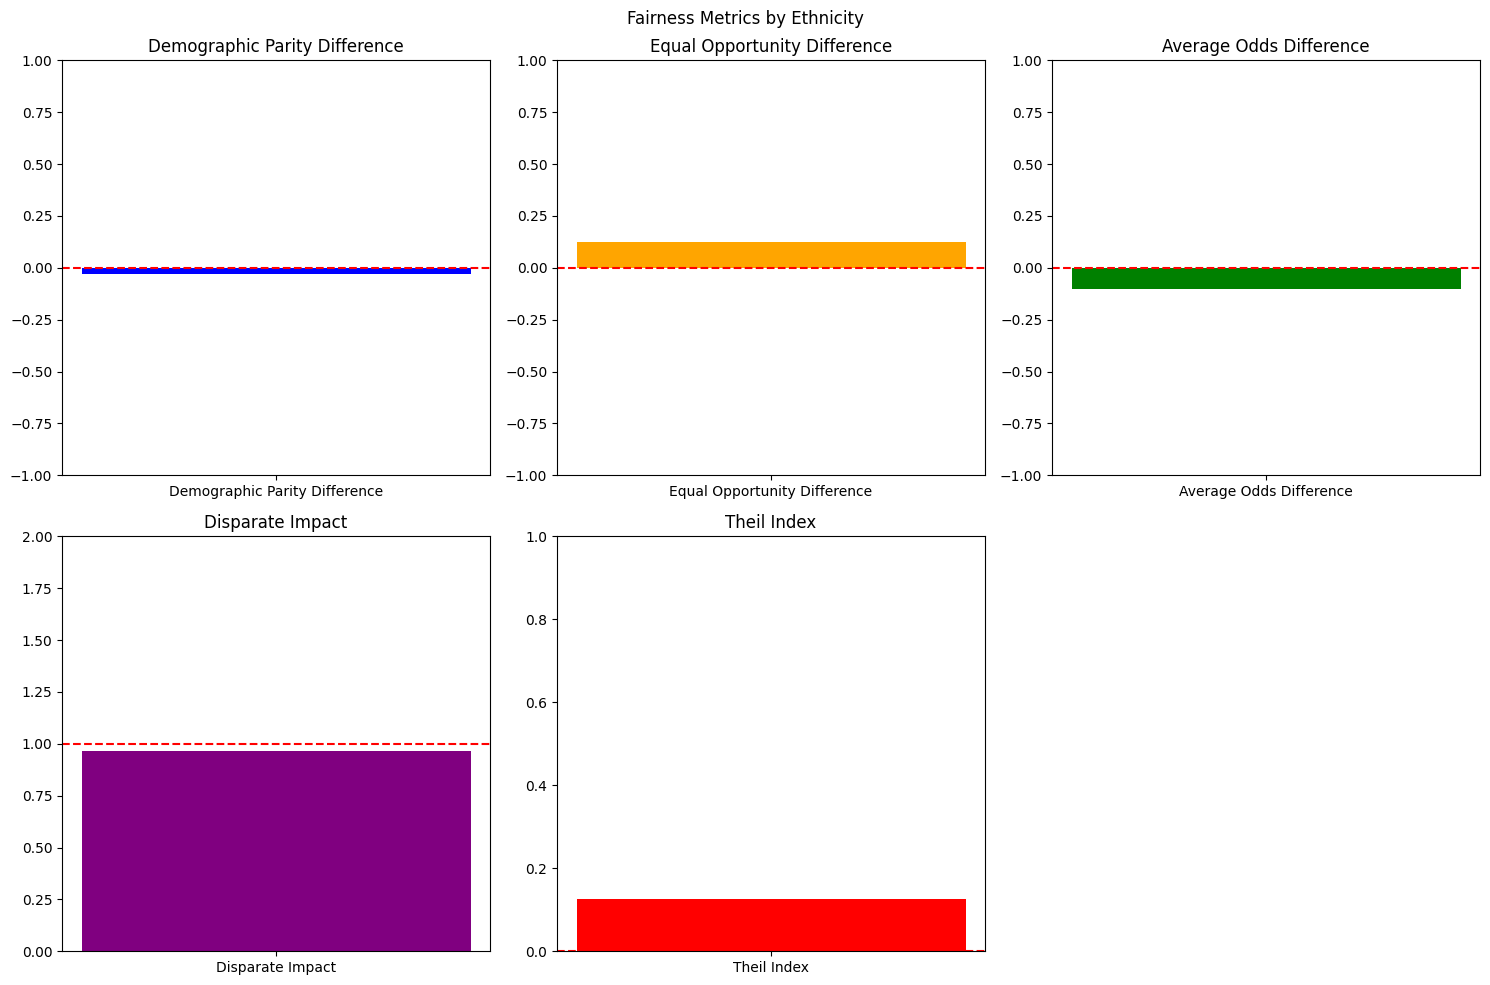

In [133]:
# Plot fairness metrics
plot_fairness_metrics(fairness_metrics_org)

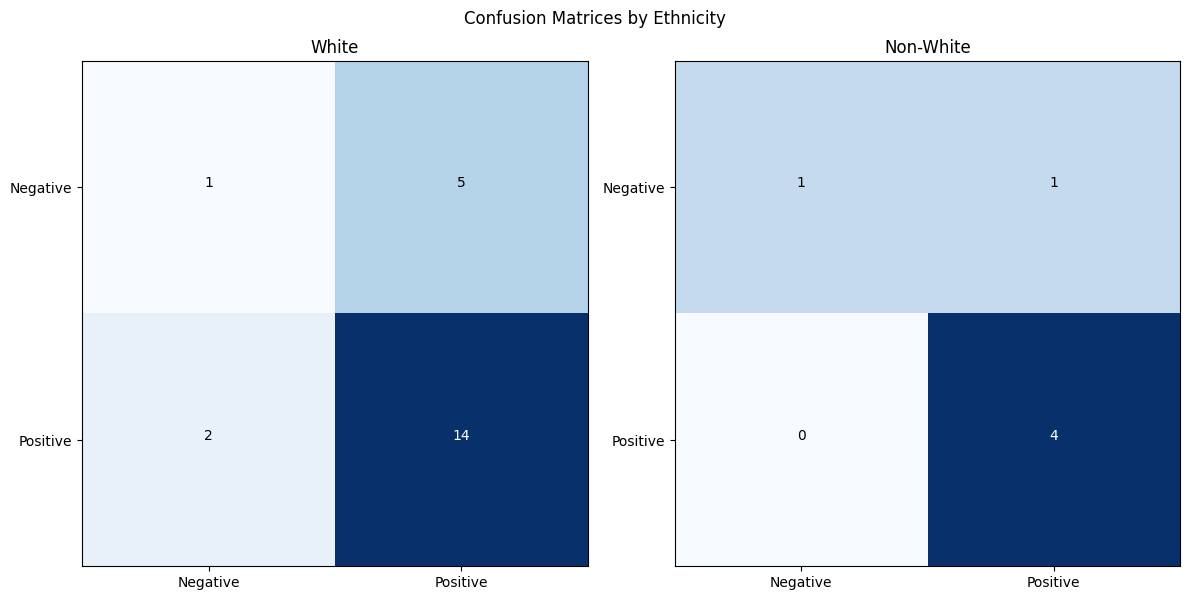

In [105]:
# Plot confusion matrices for specific ethnicity
plot_confusion_matrices_by_ethnicity(y_test.values, y_pred_xgb, X_test['ethnicity_WHITE'], X_test['ethnicity_NON-WHITE'])

Bias Mitigation using Reweighing

We'll apply the Reweighing technique to mitigate bias and retrain the model.

In [106]:
# Apply reweighing considering ethnicity
def apply_reweighing(X_train, y_train):

    # Select ethnicity columns
    privileged_ethnicity = 'ethnicity_WHITE'
    unprivileged_ethnicity = 'ethnicity_NON-WHITE'

    # Define privileged and unprivileged groups
    privileged_ethnicity_groups = [{privileged_ethnicity: 1}]
    unprivileged_ethnicity_groups = [{unprivileged_ethnicity: 1}]
    
    binary_train = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1), label_names=['survival'], protected_attribute_names=[privileged_ethnicity, unprivileged_ethnicity])
    reweighing = Reweighing(unprivileged_groups=unprivileged_ethnicity_groups, privileged_groups=privileged_ethnicity_groups)
    binary_train_reweighed = reweighing.fit_transform(binary_train)
    
    return binary_train_reweighed.instance_weights


In [107]:
# Apply reweighing to mitigate bias
instance_weights = apply_reweighing(X_train, y_train)

In [128]:
# Train and evaluate models applying bias mitigation algorithm
def train_and_evaluate_models_bias_mitigate(X_train_scaled, y_train, X_test_scaled, y_test, instance_weights=None):
    # Random Forest
    model_rf = RandomForestClassifier(
        max_depth=3, 
        min_samples_leaf= 3, 
        min_samples_split=3, 
        n_estimators=100, 
        random_state=42
        )
    model_rf.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_rf = model_rf.predict(X_test_scaled)
    display(Markdown("### With Bias Mitigation"))
    display_perform_metrics(y_test, y_pred_rf, title='Random Forest')

    # XGBoost
    # Define the XGBoost parameters
    model_xgb = xgb.XGBClassifier(
        n_estimators=200,
        gamma=0.1,
        learning_rate=0.2,
        max_depth=6,
        min_child_weight=3,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
        )
    model_xgb.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_xgb = model_xgb.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_xgb, title= 'XGBoost')

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', model_rf), 
                    ('xgb', model_xgb)], 
                    voting='soft'
                    )
    voting_clf.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_voting = voting_clf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_voting, title='Voting Classifier')

    return model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting

In [129]:
# Train and evaluate models with reweighed data
model_rf_bm, model_xgb_bm, voting_clf_bm, y_pred_rf_bm, y_pred_xgb_bm, _ = train_and_evaluate_models_bias_mitigate(X_train_scaled, y_train, X_test_scaled, y_test, instance_weights)

### With Bias Mitigation

#### For Random Forest Model 

Accuracy: 0.71


#### Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

#### For XGBoost Model 

Accuracy: 0.68


#### XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.74      0.85      0.79        20

    accuracy                           0.68        28
   macro avg       0.57      0.55      0.55        28
weighted avg       0.64      0.68      0.65        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### For Voting Classifier Model 

Accuracy: 0.68


#### Voting Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.70      0.95      0.81        20

    accuracy                           0.68        28
   macro avg       0.35      0.47      0.40        28
weighted avg       0.50      0.68      0.58        28



In [130]:
# Perform bias detection and evaluate fairness metrics
fairness_metrics_bm = perform_bias_detection_by_ethnicity(X_test, y_test, y_pred_xgb_bm)

### Ethnicity Bias Analysis - 

Disparate Impact: 0.917


  No significant bias detected: The model predictions are balanced with respect to ethnicity.

### Fairness Metrics by Ethnicity:

Demographic Parity Difference: 0.015
Equal Opportunity Difference: 0.188
Average Odds Difference: -0.073
Disparate Impact: 1.019
Theil Index: 0.167


In [131]:
# Plot comparative fairness metrics
def plot_comparative_fairness_metrics(fairness_metrics, fairness_metrics_bm):
    metrics = list(fairness_metrics.keys())
    values = list(fairness_metrics.values())
    values_bm = list(fairness_metrics_bm.values())

    groups = ['Original', 'Mitigated']
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Comparative Fairness Metrics')

    axs[0, 0].bar(groups, [values[0],values_bm[0]], color=['blue', 'orange'])
    axs[0, 0].set_ylim(-1, 1)
    axs[0, 0].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 0].set_title(metrics[0])

    axs[0, 1].bar(groups, [values[1],values_bm[1]], color=['blue', 'orange'])
    axs[0, 1].set_ylim(-1, 1)
    axs[0, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 1].set_title(metrics[1])

    axs[0, 2].bar(groups, [values[2],values_bm[2]], color=['blue', 'orange'])
    axs[0, 2].set_ylim(-1, 1)
    axs[0, 2].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 2].set_title(metrics[2])

    axs[1, 0].bar(groups, [values[3],values_bm[3]], color=['blue', 'orange'])
    axs[1, 0].set_ylim(0, 2)
    axs[1, 0].axhline(y=1.0, color='r', linestyle='--')
    axs[1, 0].set_title(metrics[3])

    axs[1, 1].bar(groups, [values[4],values_bm[4]], color=['blue', 'orange'])
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[1, 1].set_title(metrics[4])

    fig.delaxes(axs[1, 2])  
    plt.tight_layout()
    plt.show()

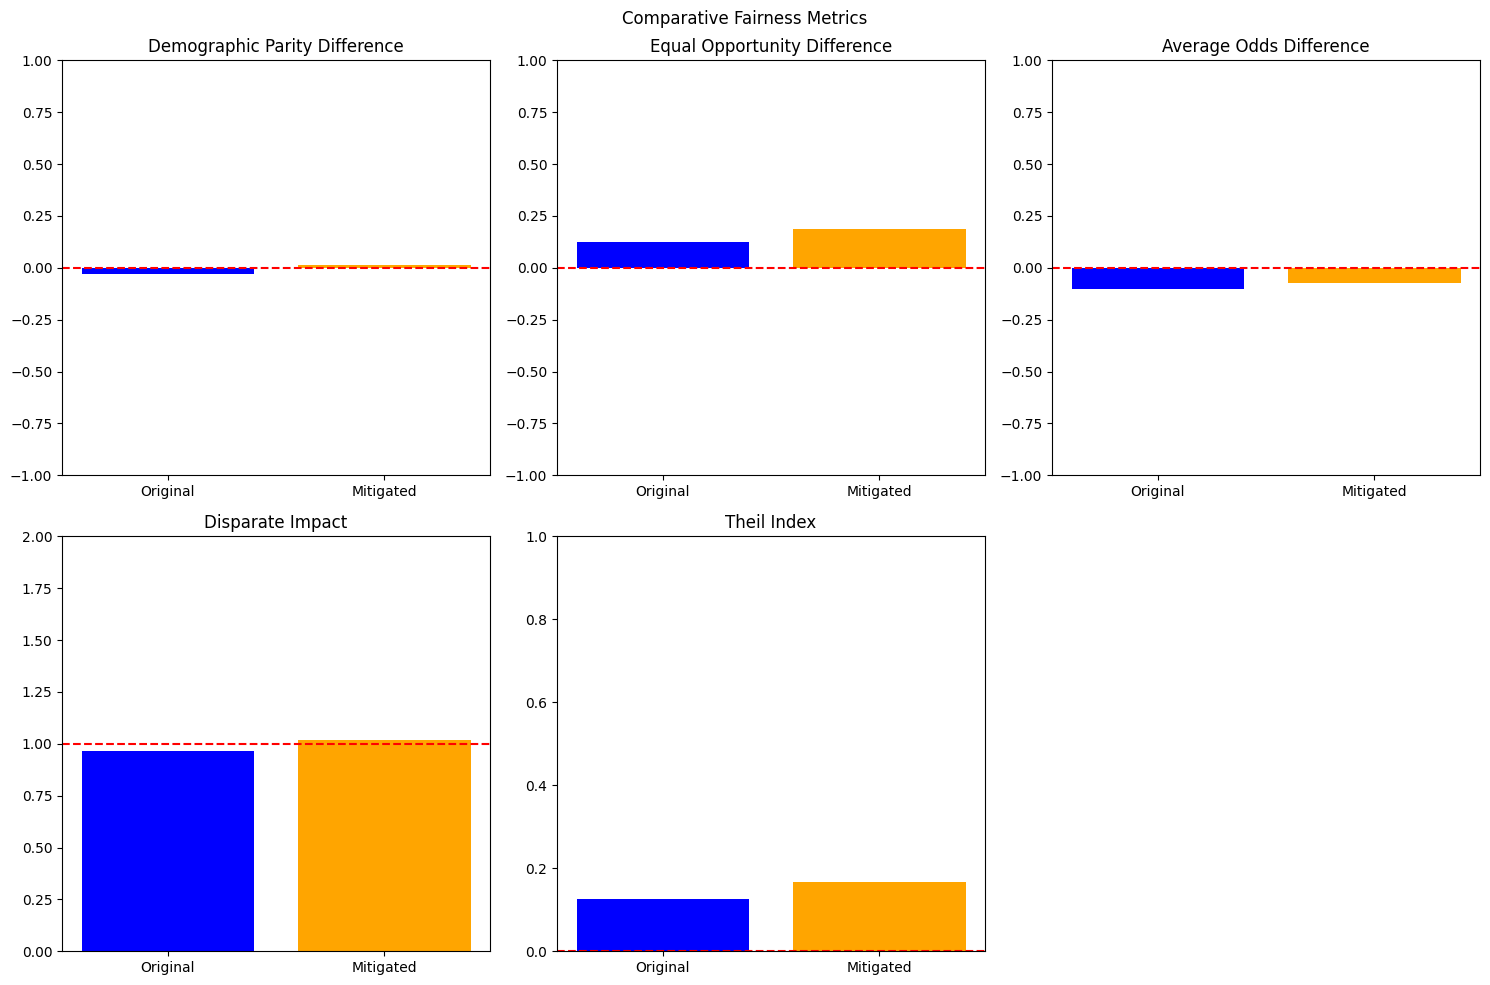

In [134]:
plot_comparative_fairness_metrics(fairness_metrics_org, fairness_metrics_bm)

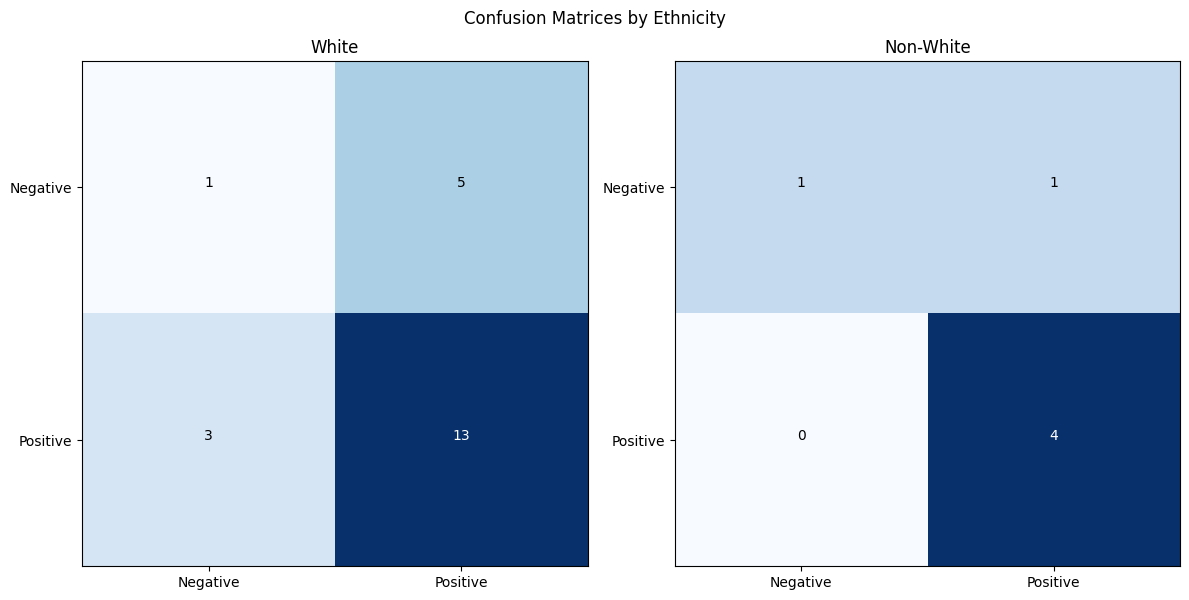

In [135]:
# Plot confusion matrices

plot_confusion_matrices_by_ethnicity(y_test.values, y_pred_xgb_bm, X_test['ethnicity_WHITE'], X_test['ethnicity_NON-WHITE'])